## DATA-255 Homework-4, Part 1





Part1: Using available pre-trained models for object detection, conduct inference on a short video (5-10 seconds) of a street scene drawing bounding boxes around detected vehicles.

Step 1. Collect a source video. It may be necessary to divide the video into discrete image frames.

Step 2. Conduct inference on each frame of the video, drawing bounding boxes around detected vehicles.

Step 3. Format the results back into a video.

The Video is sourced from youtube : https://www.youtube.com/watch?v=Y1jTEyb3wiI and is trimmed to 5 second video and named as traffic.mp4

Github : https://github.com/jyanimaulik/Deep-Learning/tree/main/Homework%204

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1879613184001599848
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15510929408
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12035651758061222782
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
 xla_global_id: 416903419]

In [4]:
import cv2
import os
import pathlib
import glob

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [5]:
# object is created to capture video data from a video file
vidcap = cv2.VideoCapture("traffic.mp4")

**Reading Data using CV2**

In [6]:
import cv2
import os

# reading frames from the vidcap object (which has stored video data)
success, image = vidcap.read()

# It is the folder where we are supposed to save the images (frames from the video)
folder_path = "image"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

count = 0
while success:
    file_path = os.path.join(folder_path, "image" + str(count) + ".jpg")
    cv2.imwrite(file_path, image)
    success, image = vidcap.read()
    #print('Read a new frame: ', success)
    count += 1


In [7]:
# function to loading an image into a NumPy array
def image_to_numpy(path):
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [8]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4084, done.
remote: Counting objects: 100% (4084/4084), done.
remote: Compressing objects: 100% (3070/3070), done.
remote: Total 4084 (delta 1189), reused 2889 (delta 954), pack-reused 0
Receiving objects: 100% (4084/4084), 44.61 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (1189/1189), done.


In [9]:
pip install tensorflow-object-detection-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.5 MB/s eta 0:00:00
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844486 sha256=fdbe503e082e4af5199394d53561274ccf0b0f1475b6014480f68e46b3c7f5ae
  Stored in directory: /root/.cache/pip/wheels/8a/55/68/c084bc2cd93c41fd8f7e2ef9e6bbcb2c35a3e4b49e42044d02
Successfully built tensorflow-object-detection-api


### **Using inception net V2**

In [10]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
%matplotlib inline
label_map_util.tf = tf.compat.v1
tf.gfile = tf.io.gfile

In [11]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [12]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = "https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1"

print('Model: '+ model_display_name)
print('TensorFlow Hub: {}'.format(model_handle))

Model: Mask R-CNN Inception ResNet V2 1024x1024
TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [13]:
# Model loaded
hub_model = hub.load(model_handle)
print('model loaded!')

model loaded!


In [14]:
# In the folder where we are supposed to save the bounded boxed images
folder_path = "boxed_images"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

w, h = 515, 512
for i in range(0, 300):
  image_np = image_to_numpy("image/image"+str(i)+".jpg")
  results = hub_model(image_np)
  result = {key:value.numpy() for key,value in results.items()}
  label_id_offset = 0
  image_np_with_detections = image_np.copy()

  keypoints, keypoint_scores = None, None
  if 'detection_keypoints' in result:
    keypoints = result['detection_keypoints'][0]
    keypoint_scores = result['detection_keypoint_scores'][0]

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections[0],
        result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        keypoints=keypoints)

  data = np.zeros((h, w, 3), dtype=np.uint8)
  img = Image.fromarray(image_np_with_detections[0], 'RGB')
  img.save("boxed_images/images"+str(i)+".jpg")

In [15]:
plt.imsave("boxed_images/images"+str(i)+".jpg", img)

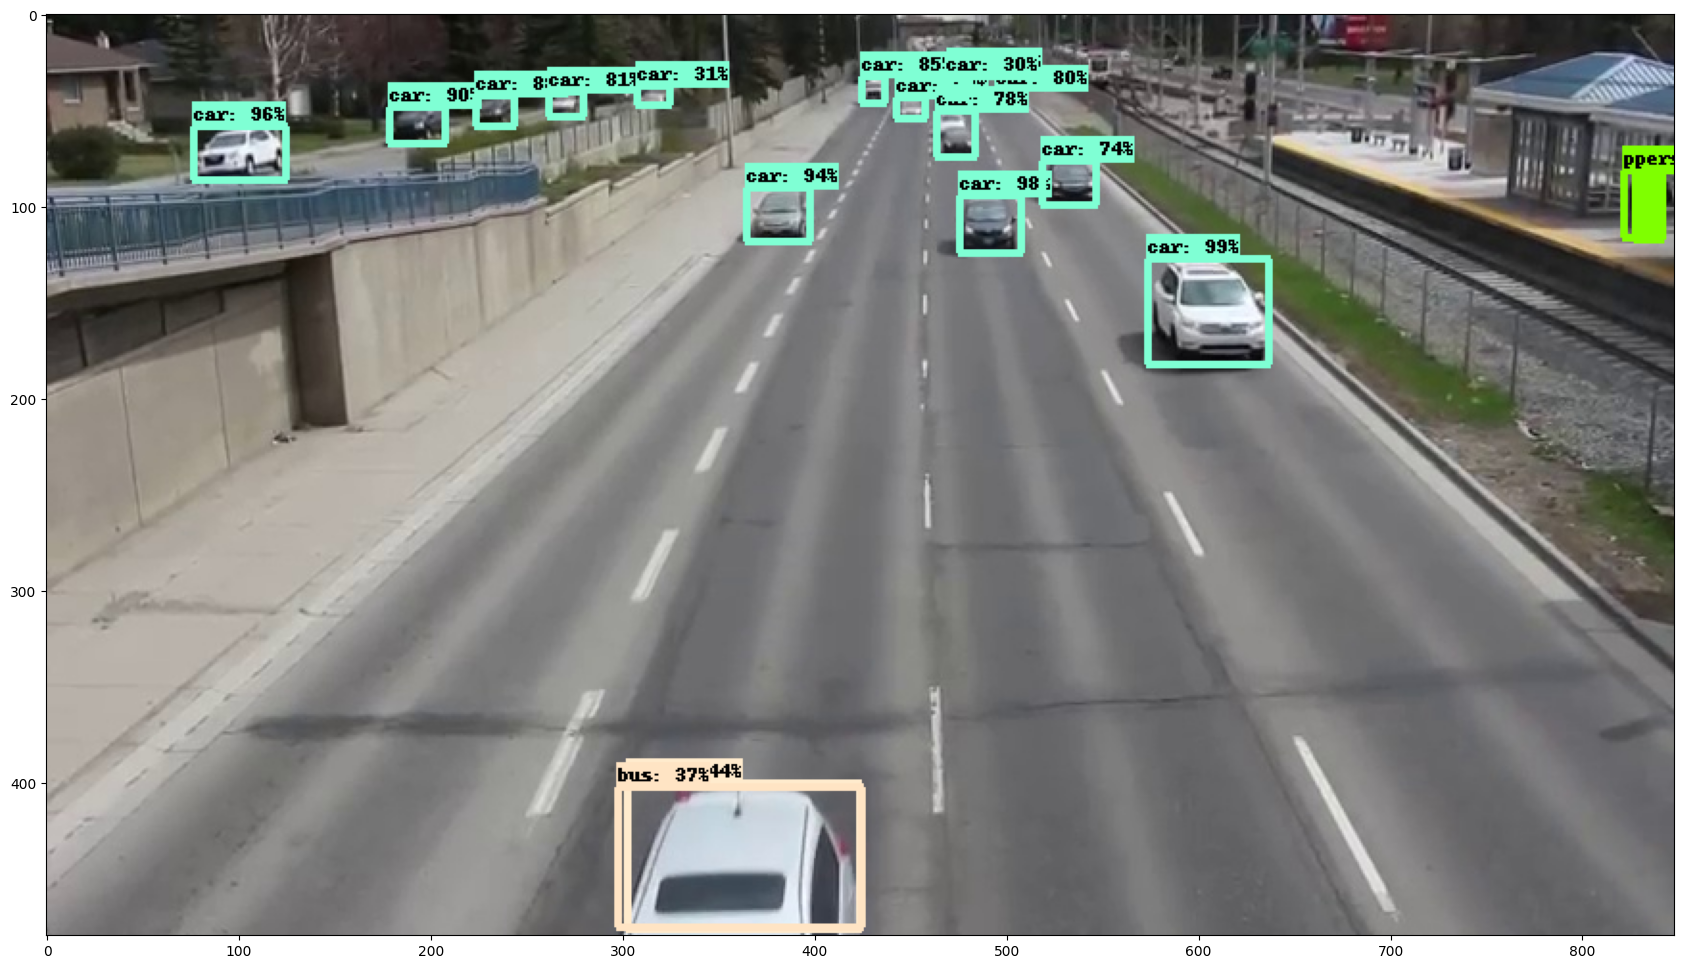

In [16]:
# display an detected vehicle image with bounded boxes
plt.figure(figsize=(21,28))
plt.imshow(image_np_with_detections[0])
plt.show()

In [18]:
# collect all the boundex box image frames and combining them to write as a video "final_output_video.mp4"
img_array = []
for i in range(0,300):
    img = cv2.imread("boxed_images/images"+str(i)+".jpg")
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter("final_output_video.mp4",cv2.VideoWriter_fourcc(*'DIVX'), 50, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()